In [1]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import json
import os.path
import random
import re
import time
import cv2
import requests
import pandas as pd
import progressbar
import tarfile
import tensorflow as tf
import zipfile
import matplotlib
import requests

from distutils.version import StrictVersion
from imutils import paths
from PIL import Image

2023-02-13 21:03:46.463743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 21:03:51.913149: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-13 21:04:05.509990: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lee/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-13 21:04:05.5104

In [2]:
print ("Tensorflow: {}".format(tf.__version__))

Tensorflow: 2.11.0


In [146]:
# network image size
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 64

# license number construction
DOWNSAMPLE_FACTOR = 2 ** 2  # <= pool size ** number of pool layers
MAX_TEXT_LEN = 10

In [147]:
ILP_HDF5 = 'data/license_recognition/ilp.h5'
BACKGRND_HDF5 = 'data/license_recognition/background.h5'

BATCH_SIZE = 16
NUM_EPOCHS = 1000

# supported optimizer methods: sdg, rmsprop, adam, adagrad, adadelta
OPTIMIZER = 'adadelta'

OUTPUT_PATH = 'output/license_recognition'
DOCUMENTATION_PATH = 'documentation'
MODEL_NAME = 'ilpr-model'

MODEL_WEIGHTS_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + '-weights.h5'
MODEL_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + ".h5"
SAVED_MODEL_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, "saved_model")
TFLITE_MODEL_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + ".tflite"
    
TEST_IMAGES = 'data/license_recognition/plate_images'

# create model output directory
os.makedirs(os.path.join(OUTPUT_PATH, OPTIMIZER), exist_ok=True)

print("GLP Dataset:        {}".format(ILP_HDF5))
print("Background Dataset: {}".format(BACKGRND_HDF5))
print("Batch Size:         {}".format(BATCH_SIZE))
print("Epochs (max):       {}".format(NUM_EPOCHS))
print("Image Size:         ({}, {})".format(IMAGE_WIDTH, IMAGE_HEIGHT))
print("Optimizer:          {}".format(OPTIMIZER))
print("Model Name:         {}".format(MODEL_NAME))
print("Output Path:        {}".format(OUTPUT_PATH))
print("Model Weights Path: {}".format(MODEL_WEIGHTS_PATH))
print("Model Path:         {}".format(MODEL_PATH))
print("Saved Model Path:   {}".format(SAVED_MODEL_PATH))
print("TFLite Model Path:  {}".format(TFLITE_MODEL_PATH))
print("Documentation Path: {}".format(DOCUMENTATION_PATH))
print("Test Images Path:   {}".format(TEST_IMAGES))

GLP Dataset:        data/license_recognition/ilp.h5
Background Dataset: data/license_recognition/background.h5
Batch Size:         16
Epochs (max):       1000
Image Size:         (128, 64)
Optimizer:          adadelta
Model Name:         ilpr-model
Output Path:        output/license_recognition
Model Weights Path: output/license_recognition/adadelta/ilpr-model-weights.h5
Model Path:         output/license_recognition/adadelta/ilpr-model.h5
Saved Model Path:   output/license_recognition/adadelta/saved_model
TFLite Model Path:  output/license_recognition/adadelta/ilpr-model.tflite
Documentation Path: documentation
Test Images Path:   data/license_recognition/plate_images


In [148]:
import math
import random

import cv2
import numpy as np


class LicensePlateImageAugmentor:
    def __init__(self, img_w, img_h, background_images):

        self.OUTPUT_SHAPE = img_h, img_w
        self.background_images, _ = background_images

    def __get_random_background_image__(self):
        index = random.randint(0, len(self.background_images) - 1)
        return self.background_images[index]

    def __generate_background_image__(self):
        background = self.__get_random_background_image__()
        x = random.randint(0, background.shape[1] - self.OUTPUT_SHAPE[1])
        y = random.randint(0, background.shape[0] - self.OUTPUT_SHAPE[0])
        background = background[y:y + self.OUTPUT_SHAPE[0], x:x + self.OUTPUT_SHAPE[1]]
        return background

    @staticmethod
    def __euler_to_mat__(yaw, pitch, roll):
        # Rotate clockwise about the Y-axis
        c, s = math.cos(yaw), math.sin(yaw)
        M = np.matrix([[c, 0., s],
                       [0., 1., 0.],
                       [-s, 0., c]])

        # Rotate clockwise about the X-axis
        c, s = math.cos(pitch), math.sin(pitch)
        M = np.matrix([[1., 0., 0.],
                       [0., c, -s],
                       [0., s, c]]) * M

        # Rotate clockwise about the Z-axis
        c, s = math.cos(roll), math.sin(roll)
        M = np.matrix([[c, -s, 0.],
                       [s, c, 0.],
                       [0., 0., 1.]]) * M

        return M

    def __make_affine_transform__(self, from_shape, to_shape, rotation_variation=1.0):

        from_size = np.array([[from_shape[1], from_shape[0]]]).T
        to_size = np.array([[to_shape[1], to_shape[0]]]).T

        roll = random.uniform(-0.3, 0.3) * rotation_variation
        pitch = random.uniform(-0.2, 0.2) * rotation_variation
        yaw = random.uniform(-1.2, 1.2) * rotation_variation

        scale = 0.8

        center_to = to_size / 2.
        center_from = from_size / 2.

        M = self.__euler_to_mat__(yaw, pitch, roll)[:2, :2]
        M *= scale
        M = np.hstack([M, center_to - M * center_from])

        return M

    @staticmethod
    def __gaussian_noise__(image, sigma=1):
        mean = 0.0
        gauss = np.random.normal(mean, sigma, image.shape)
        image = image + gauss
        return image

    @staticmethod
    def __brightness__(img, factor=0.5):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  # convert to hsv
        hsv = np.array(hsv, dtype=np.float64)
        hsv[:, :, 2] = hsv[:, :, 2] * (factor + np.random.uniform())  # scale channel V uniformly
        hsv[:, :, 2][hsv[:, :, 2] > 255] = 255  # reset out of range values
        rgb = cv2.cvtColor(np.array(hsv, dtype=np.uint8), cv2.COLOR_HSV2RGB)
        return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

    @staticmethod
    def __blur__(img):
        blur_value = random.randint(0, 2) + 1
        img = cv2.blur(img, (blur_value, blur_value))
        return img

    @staticmethod
    def __normalize_image__(image):
        # normalize image data between 0 and 1
        # image = (image - image.min()) / (image.max() - image.min())
        image = image.astype(np.float32) / 255.
        return image

    def generate_plate_image(self, plate_img):
        bi = self.__generate_background_image__()

        random_brightness = random.uniform(0.0, 0.7)
        bi = self.__brightness__(bi, random_brightness)
        plate_img = self.__brightness__(plate_img, random_brightness)

        M = self.__make_affine_transform__(
            from_shape=plate_img.shape,
            to_shape=bi.shape,
            rotation_variation=0.8)

        plate_mask = np.ones(plate_img.shape)
        plate_img = cv2.warpAffine(plate_img, M, (bi.shape[1], bi.shape[0]))
        plate_mask = cv2.warpAffine(plate_mask, M, (bi.shape[1], bi.shape[0]))

        out = plate_img * plate_mask + bi * (1.0 - plate_mask)
        #out = self.__gaussian_noise__(out, random.randrange(1, 10))
        out = self.__blur__(out)
        out = self.__normalize_image__(out)
        return out

In [149]:
import h5py
import numpy as np


class Hdf5DatasetLoader:
    def __init__(self, preprocessors=None):
        self.preprocessors = preprocessors

        # if the preprocessors are None, initialize them as an empty list
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, db_path, shuffle=False, max_items=np.inf):

        db = h5py.File(db_path, 'r')
        images = np.array(db["images"])
        labels = np.array(db["labels"])
        db.close()

        if shuffle:
            randomized_indexes = np.arange(len(images))
            np.random.shuffle(randomized_indexes)
            images = images[randomized_indexes]
            labels = labels[randomized_indexes]

        if max_items == np.inf or max_items > len(images):
            max_items = len(images)

        images = images[0:max_items]
        labels = labels[0:max_items]

        # preprocess images
        for i, (image, label) in enumerate(zip(images, labels)):

            for p in self.preprocessors:
                image = p.preprocess(image)
                images[i] = image

        return images, labels

In [150]:
loader = Hdf5DatasetLoader()
background_images = loader.load(BACKGRND_HDF5, shuffle=True, max_items=100000)
images, labels = loader.load(ILP_HDF5, shuffle=True)

In [151]:
def show_images(images, labels, figsize=(15, 5)):
    cols = 5
    rows = len(images) // cols

    image_index = 0
    fig, axarr = plt.subplots(rows, cols, figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            image = images[image_index]
            axarr[r, c].axis("off")
            axarr[r, c].title.set_text(labels[image_index].decode())
            axarr[r, c].imshow(image, cmap='gray')
            image_index += 1

    plt.show()

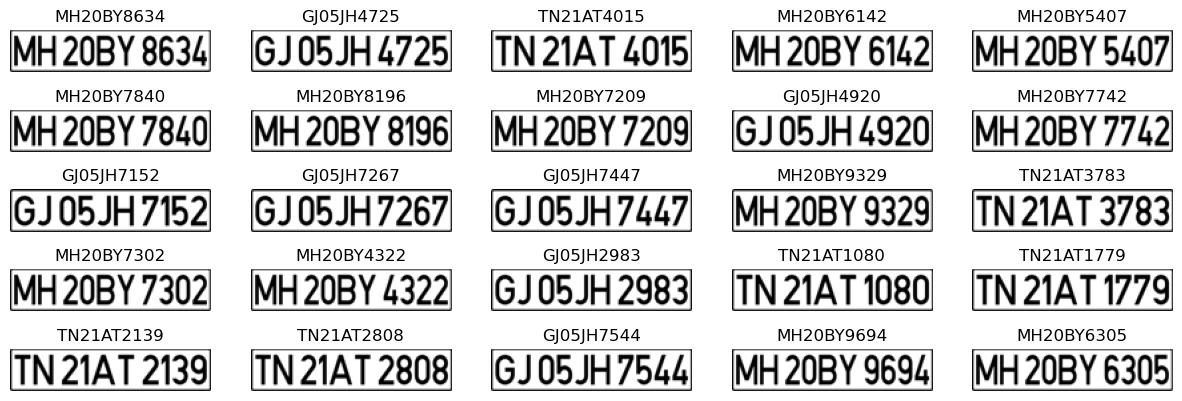

In [152]:
show_images(images[:25], labels[:25])

In [153]:
augmentor = LicensePlateImageAugmentor(IMAGE_WIDTH, IMAGE_HEIGHT, background_images)

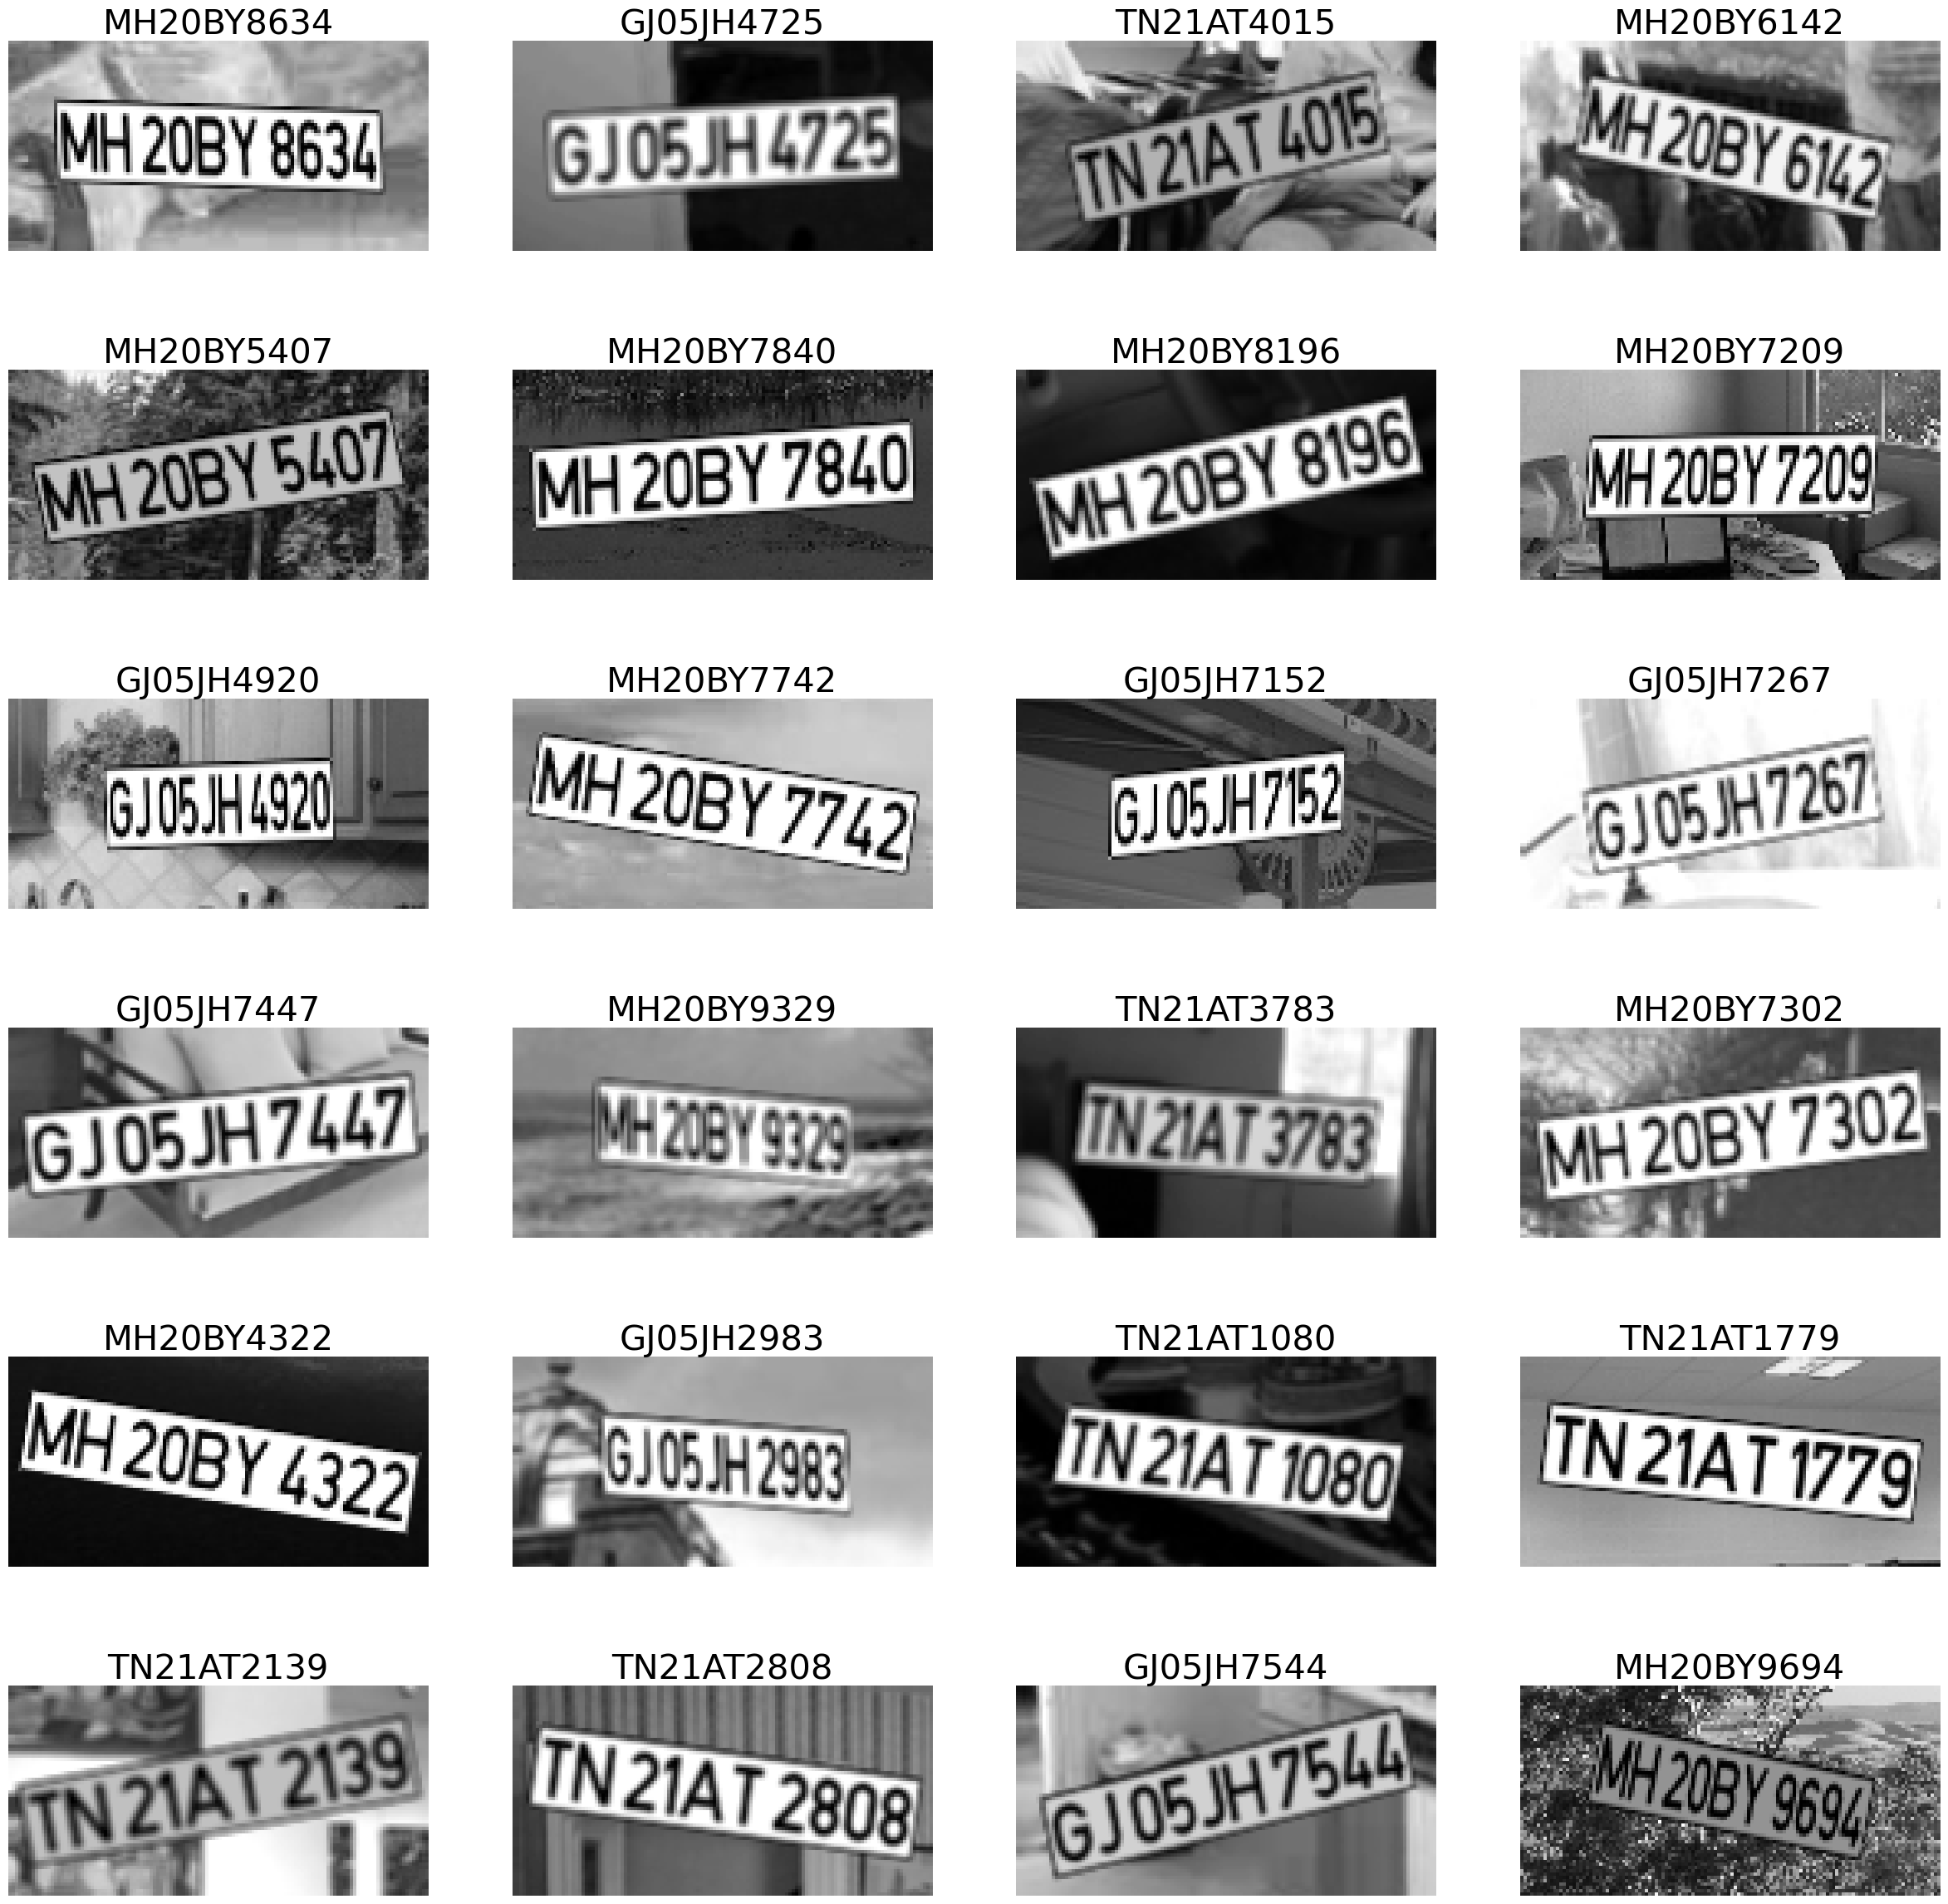

In [154]:
cols = 4
rows = 6

image_index = 0
fig, axarr = plt.subplots(rows, cols, figsize=(30, 30))
for r in range(rows):
    for c in range(cols):
        image = images[image_index]
        image = augmentor.generate_plate_image(image)
        axarr[r, c].axis("off")
        axarr[r, c].title.set_size(30)
        axarr[r, c].title.set_text(labels[image_index].decode())
        axarr[r, c].imshow(image, cmap='gray')
        image_index += 1

plt.show()

In [155]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Train dataset size:      {}".format(X_train.shape[0]))
print("Validation dataset size: {}".format(X_val.shape[0]))
print("Test dataset size:       {}".format(X_test.shape[0]))

Train dataset size:      11809
Validation dataset size: 2953
Test dataset size:       3691


In [156]:
import itertools
import numpy as np


class LabelCodec:
    ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789- "

    # Translation of characters to unique numerical classes
    @staticmethod
    def encode_number(number):
        return list(map(lambda c: LabelCodec.ALPHABET.index(c), number))

    # Reverse translation of numerical classes back to characters
    @staticmethod
    def decode_number(label):
        return ''.join(list(map(lambda x: LabelCodec.ALPHABET[int(x)], label)))

    @staticmethod
    def decode_prediction(prediction):
        out_best = list(np.argmax(prediction, axis=1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(LabelCodec.ALPHABET):
                outstr += LabelCodec.ALPHABET[c]
        return outstr

In [157]:
import random

import numpy as np


class LicensePlateDatasetGenerator:
    def __init__(self, images, labels, img_w, img_h, downsample_factor, max_text_len, batch_size, augmentor):

        self.img_w = img_w
        self.img_h = img_h
        self.max_text_len = max_text_len
        self.batch_size = batch_size
        self.input_length = img_w // downsample_factor

        self.images = images
        self.labels = labels
        self.numImages = self.labels.shape[0]

        self.indexes = np.asarray(range(self.numImages))
        random.shuffle(self.indexes)
        self.batch_index = 0

        self.augmentor = augmentor

    def next_batch(self):

        if self.batch_index >= (self.numImages // self.batch_size):
            self.batch_index = 0
            random.shuffle(self.indexes)

        current_index = self.batch_index * self.batch_size
        batch_indexes = self.indexes[current_index:current_index + self.batch_size]
        self.batch_index += 1
        return self.images[batch_indexes], self.labels[batch_indexes]

    def generator(self, passes=np.inf):
        # initialize the epoch count
        epochs = 0

        # keep looping infinitely -- the model will stop once we have
        # reach the desired number of epochs
        while epochs < passes:

            data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            labels = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * self.input_length
            label_length = np.zeros((self.batch_size, 1))

            x_data, y_data = self.next_batch()

            for i, (image, number) in enumerate(zip(x_data, y_data)):
                image = self.augmentor.generate_plate_image(image)
                data[i] = np.expand_dims(image.T, -1)
                text_length = len(number)
                labels[i, 0:text_length] = LabelCodec.encode_number(number.decode())
                label_length[i] = text_length

            yield {'input': data, 'labels': labels, 'input_length': input_length, 'label_length': label_length}

            # increment the total number of epochs
            epochs += 1

In [158]:
train_generator = LicensePlateDatasetGenerator(X_train, y_train, IMAGE_WIDTH, IMAGE_HEIGHT,
                                               DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                               augmentor)

val_generator = LicensePlateDatasetGenerator(X_val, y_val, IMAGE_WIDTH, IMAGE_HEIGHT,
                                             DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                             augmentor)

test_generator = LicensePlateDatasetGenerator(X_test, y_test, IMAGE_WIDTH, IMAGE_HEIGHT,
                                              DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                              augmentor)

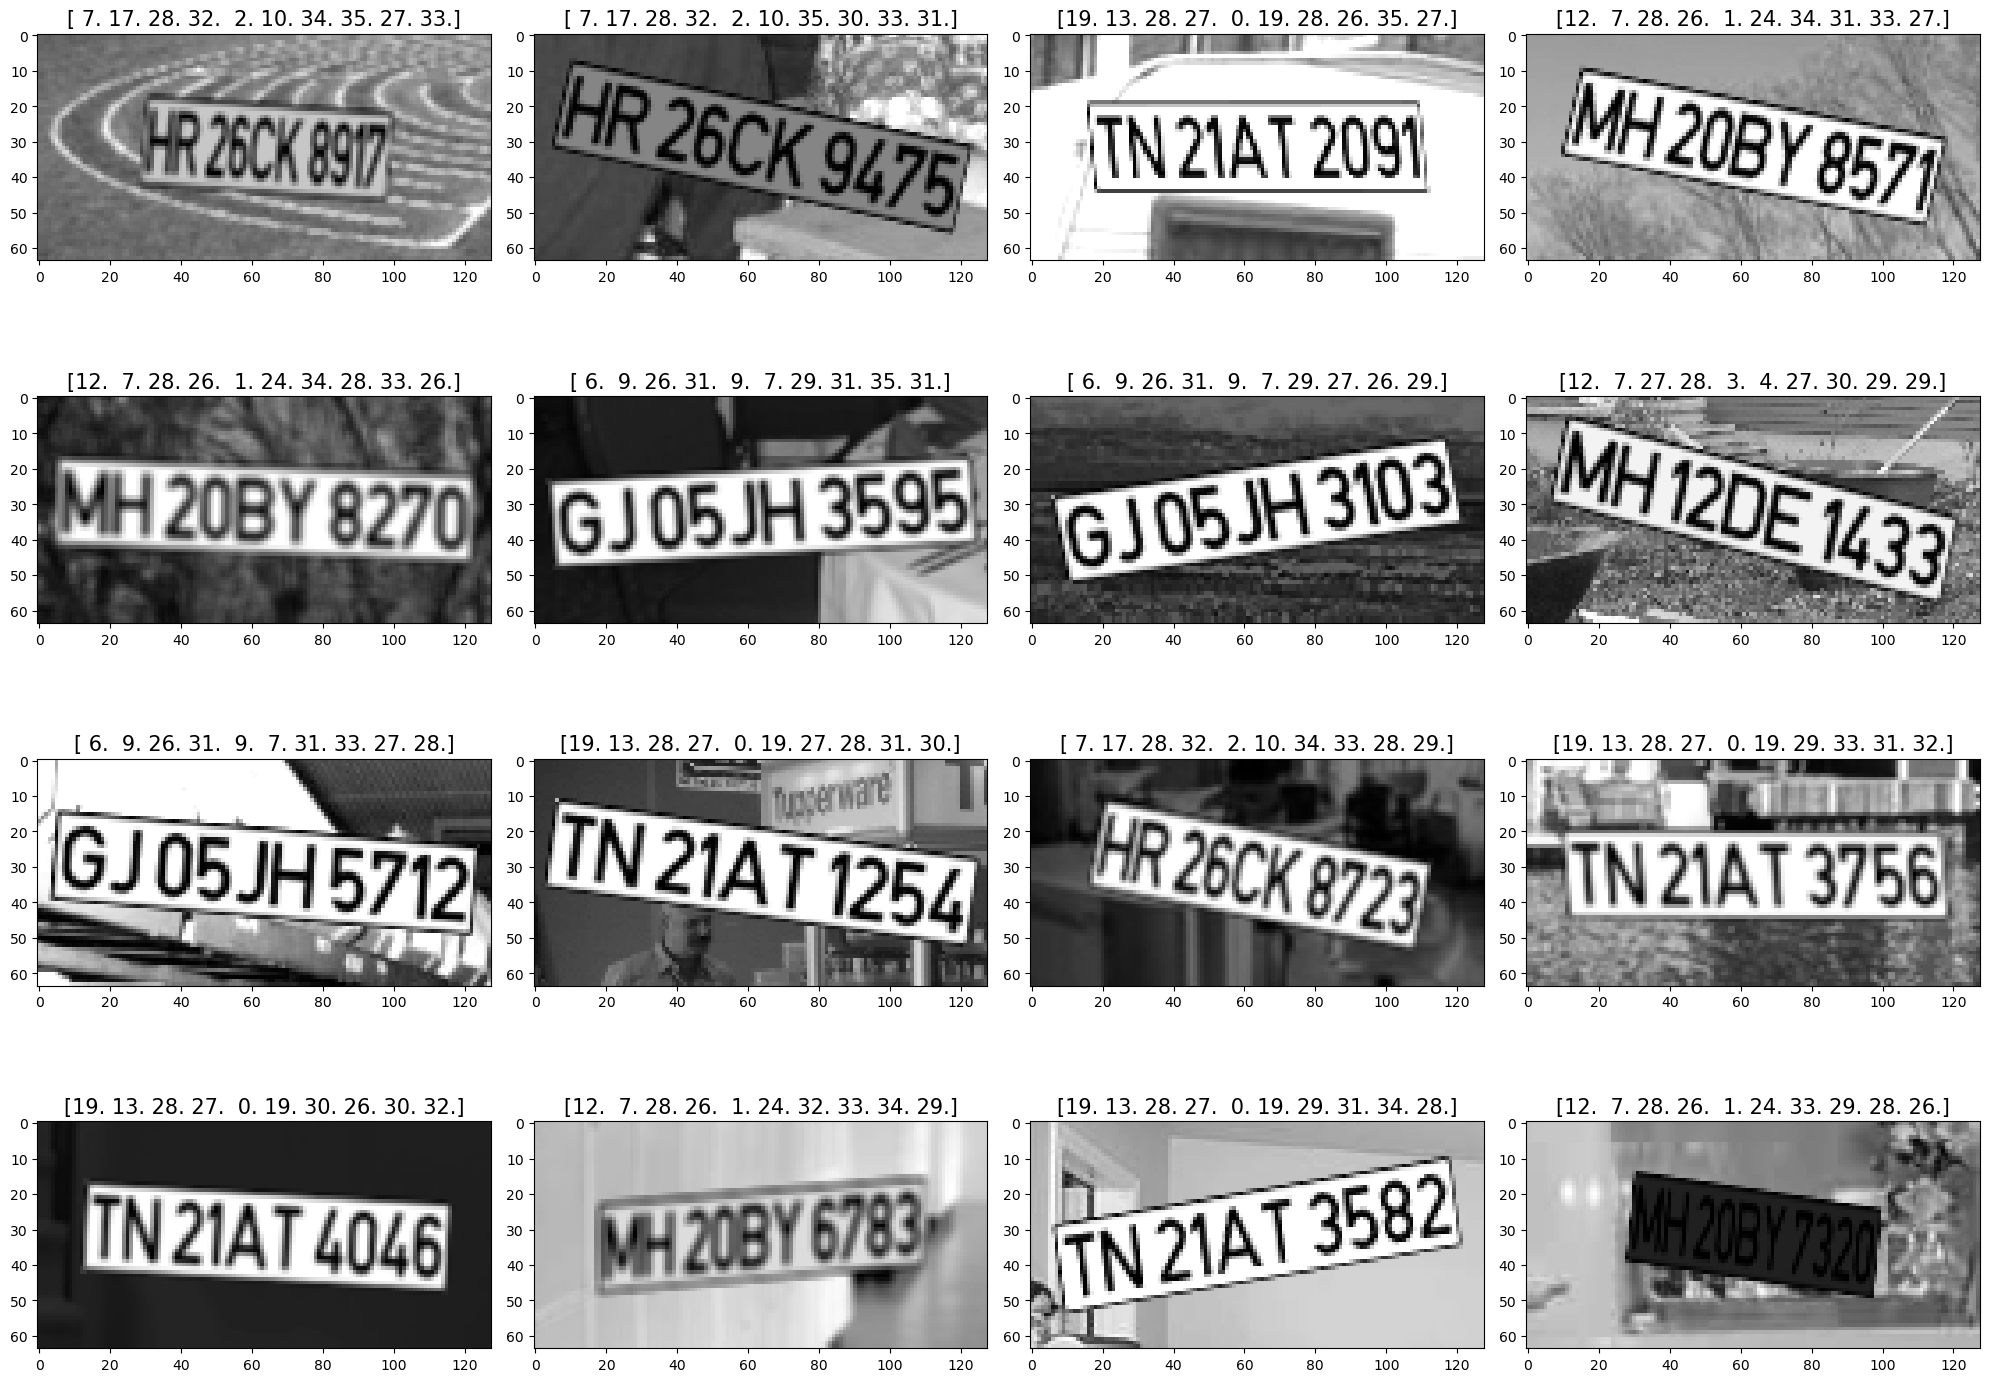

In [159]:
inputs = next(train_generator.generator())

def plotImages(images_arr, labels, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(20,15))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        img = img.T.reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        ax.title.set_size(15)
        ax.title.set_text(label)
        ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()
        
plotImages(inputs["input"], inputs["labels"], int(16 / 4), 4)

In [160]:
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, LSTM, GRU, Bidirectional,
    Input, Dense, Activation, Reshape, BatchNormalization, add, concatenate
)


class OCR:
    @staticmethod
    def conv_bgru(input_shape, output_size):
        conv_filters = 16
        kernel_size = (3, 3)
        pool_size = 2
        time_dense_size = 32
        rnn_size = 512

        input_data = Input(name="input", shape=input_shape)

        cnn = Conv2D(conv_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_data)
        cnn = BatchNormalization()(cnn)
        cnn = Activation('relu')(cnn)
        cnn = MaxPooling2D(pool_size=(pool_size, pool_size))(cnn)

        cnn = Conv2D(conv_filters, kernel_size, padding='same', kernel_initializer='he_normal')(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = Activation('relu')(cnn)
        cnn = MaxPooling2D(pool_size=(pool_size, pool_size))(cnn)

        # CNN to RNN
        shape = cnn.get_shape()
        cnn = Reshape((shape[1], shape[2] * shape[3]))(cnn)
        dense = Dense(time_dense_size, activation='relu', kernel_initializer='he_normal')(cnn)

        # RNN layer
        bgru = Bidirectional(GRU(units=rnn_size, return_sequences=True), merge_mode="sum")(dense)
        bgru = BatchNormalization()(bgru)
        bgru = Bidirectional(GRU(units=rnn_size, return_sequences=True), merge_mode="concat")(bgru)
        bgru = BatchNormalization()(bgru)

        # transforms RNN output to character activations:
        dense = Dense(output_size, kernel_initializer='he_normal')(bgru)
        output_data = Activation("softmax", name="output")(dense)

        return input_data, output_data

    @staticmethod
    def conv_blstm(input_shape, output_size):
        conv_filters = 16
        kernel_size = (3, 3)
        pool_size = 2
        time_dense_size = 32
        rnn_size = 512

        input_data = Input(name="input", shape=input_shape)

        cnn = Conv2D(conv_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_data)
        cnn = BatchNormalization()(cnn)
        cnn = Activation('relu')(cnn)
        cnn = MaxPooling2D(pool_size=(pool_size, pool_size))(cnn)

        cnn = Conv2D(conv_filters, kernel_size, padding='same', kernel_initializer='he_normal')(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = Activation('relu')(cnn)
        cnn = MaxPooling2D(pool_size=(pool_size, pool_size))(cnn)

        # CNN to RNN
        shape = cnn.get_shape()
        cnn = Reshape((shape[1], shape[2] * shape[3]))(cnn)
        dense = Dense(time_dense_size, activation='relu', kernel_initializer='he_normal')(cnn)

        # RNN layer
        blsmt = Bidirectional(LSTM(units=rnn_size, return_sequences=True), merge_mode="sum")(dense)
        blsmt = BatchNormalization()(blsmt)
        blsmt = Bidirectional(LSTM(units=rnn_size, return_sequences=True), merge_mode="concat")(blsmt)
        blsmt = BatchNormalization()(blsmt)

        # transforms RNN output to character activations:
        dense = Dense(output_size, kernel_initializer='he_normal')(blsmt)
        output_data = Activation("softmax", name="output")(dense)

        return input_data, output_data

    @staticmethod
    def vgg_bgru(input_shape, output_size):

        input_data = Input(name='input', shape=input_shape, dtype='float32')  # (None, 128, 64, 1)
        cnn = OCR.__mini_vgg__(input_data)

        # CNN to RNN
        shape = cnn.get_shape()
        cnn = Reshape((shape[1], shape[2] * shape[3]))(cnn)
        dense = Dense(64, activation='relu', kernel_initializer='he_normal')(cnn)  # (None, 32, 64)

        # RNN layer
        bgru = Bidirectional(GRU(units=256, return_sequences=True, dropout=0.2), merge_mode="sum")(dense)
        bgru = BatchNormalization()(bgru)
        bgru = Bidirectional(GRU(units=256, return_sequences=True, dropout=0.2), merge_mode="concat")(bgru)
        bgru = BatchNormalization()(bgru)

        # transforms RNN output to character activations:
        dense = Dense(output_size, kernel_initializer='he_normal')(bgru)  # (None, 32, 42)
        output_data = Activation('softmax', name='output')(dense)

        return input_data, output_data

    @staticmethod
    def __mini_vgg__(input_data):

        cnn = Conv2D(32, (3, 3), activation='relu', padding='same')(input_data)
        cnn = BatchNormalization()(cnn)
        cnn = Conv2D(32, (3, 3), activation='relu', padding='same')(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = MaxPooling2D(pool_size=(2, 2))(cnn)

        cnn = Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = MaxPooling2D(pool_size=(2, 2))(cnn)

        return cnn

    @staticmethod
    def __vgg__(input_data):

        cnn = Conv2D(64, (3, 3), activation='relu', padding='same')(input_data)
        cnn = MaxPooling2D(pool_size=(2, 2), strides=2)(cnn)

        cnn = Conv2D(128, (3, 3), activation='relu', padding='same')(cnn)
        cnn = MaxPooling2D(pool_size=(2, 2), strides=2)(cnn)

        cnn = Conv2D(256, (3, 3), activation='relu', padding='same')(cnn)

        cnn = Conv2D(256, (3, 3), activation='relu', padding='same')(cnn)
        cnn = MaxPooling2D(pool_size=(1, 2))(cnn)

        cnn = Conv2D(512, (3, 3), activation='relu', padding='same')(cnn)
        cnn = BatchNormalization()(cnn)

        cnn = Conv2D(512, (3, 3), activation='relu', padding='same')(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = MaxPooling2D(pool_size=(1, 2))(cnn)

        cnn = Conv2D(512, (2, 2), activation='relu', padding='same')(cnn)

        return cnn

In [161]:
import os

from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


class TrainHelper:
    @staticmethod
    def get_optimizer(optimizer):
        if optimizer == "sdg":
            return SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
        if optimizer == "rmsprop":
            return RMSprop(learning_rate=0.01)
        if optimizer == "adam":
            return Adam(learning_rate=0.01)
        if optimizer == "adagrad":
            return Adagrad(learning_rate=0.01)
        if optimizer == "adadelta":
            return Adadelta(learning_rate=1.0)

    @staticmethod
    def get_callbacks(output_dir, model_name, optimizer, model_weigths_path):
        logdir = os.path.join(output_dir, optimizer, 'logs')
        chkpt_filepath = model_name + '--{epoch:02d}--{loss:.3f}--{val_loss:.3f}.h5'

        callbacks = [
            EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1),
            ModelCheckpoint(filepath=model_weigths_path, monitor='val_loss', save_best_only=True,
                            save_weights_only=True, verbose=1),
            TensorBoard(log_dir=logdir)]

        if optimizer in ["sdg", "rmsprop"]:
            callbacks.append(
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.01,
                                  cooldown=0, min_lr=0))

        return callbacks

In [162]:
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras import Input
from tensorflow.keras.models import Model
    
class CTCLoss(tf.keras.losses.Loss):

    def __init__(self, input_length, label_length, name='CTCLoss'):
        super().__init__(name=name)
        self.input_length = input_length
        self.label_length = label_length

    def call(self, labels, predictions):
        return tf.keras.backend.ctc_batch_cost(labels, predictions, self.input_length, self.label_length)

tf.compat.v1.disable_eager_execution()
#tf.compat.v1.experimental.output_all_intermediates(True)

labels = Input(name='labels', shape=(MAX_TEXT_LEN,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')

inputs, outputs = OCR.conv_bgru((IMAGE_WIDTH, IMAGE_HEIGHT, 1), len(LabelCodec.ALPHABET) + 1)

train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=outputs)
train_model.add_loss(CTCLoss(input_length, label_length)(labels, outputs))
train_model.compile(loss=None, optimizer=TrainHelper.get_optimizer(OPTIMIZER))

predict_model = Model(inputs=inputs, outputs=outputs)
predict_model.summary()

2023-02-13 22:22:13.404408: W tensorflow/c/c_api.cc:291] Operation '{name:'batch_normalization_30/gamma/Assign' id:19854 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_30/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_30/gamma, batch_normalization_30/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-13 22:22:16.635687: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss_7/weighted_loss/Const_1' id:20797 op device:{requested: '', assigned: ''} def:{{{node CTCLoss_7/weighted_loss/Const_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will

2023-02-13 22:22:38.593692: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss_7/strided_slice_1/stack' id:20590 op device:{requested: '', assigned: ''} def:{{{node CTCLoss_7/strided_slice_1/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-13 22:22:40.087892: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss_7/strided_slice_1/stack_1' id:20591 op device:{requested: '', assigned: ''} def:{{{node CTCLoss_7/strided_slice_1/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either d

2023-02-13 22:23:00.814046: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss_7/boolean_mask_1/Reshape_1/shape' id:20771 op device:{requested: '', assigned: ''} def:{{{node CTCLoss_7/boolean_mask_1/Reshape_1/shape}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-13 22:23:02.289762: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss_7/strided_slice_3/stack' id:20697 op device:{requested: '', assigned: ''} def:{{{node CTCLoss_7/strided_slice_3/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 0 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in t

2023-02-13 22:23:24.592360: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss_7/scan/TensorArrayUnstack/Const' id:20611 op device:{requested: '', assigned: ''} def:{{{node CTCLoss_7/scan/TensorArrayUnstack/Const}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [0] values: >]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-13 22:23:26.073051: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss_7/scan/while/Const' id:20617 op device:{requested: '', assigned: ''} def:{{{node CTCLoss_7/scan/while/Const}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [0] values: >]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either d

2023-02-13 22:23:46.923112: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss_7/scan/while/Const_7' id:20645 op device:{requested: '', assigned: ''} def:{{{node CTCLoss_7/scan/while/Const_7}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [0] values: >]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-13 22:23:48.398658: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss_7/scan/while/EmptyTensorList_15/element_shape' id:20647 op device:{requested: '', assigned: ''} def:{{{node CTCLoss_7/scan/while/EmptyTensorList_15/element_shape}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 10>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trig

2023-02-13 22:24:11.176921: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss_7/strided_slice/stack_1' id:20586 op device:{requested: '', assigned: ''} def:{{{node CTCLoss_7/strided_slice/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-13 22:24:12.656386: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss_7/strided_slice/stack_2' id:20587 op device:{requested: '', assigned: ''} def:{{{node CTCLoss_7/strided_slice/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 64, 1)]      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 64, 16)       160       
                                                                 
 batch_normalization_28 (Bat  (None, 128, 64, 16)      64        
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 128, 64, 16)       0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 64, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 32, 16)        232

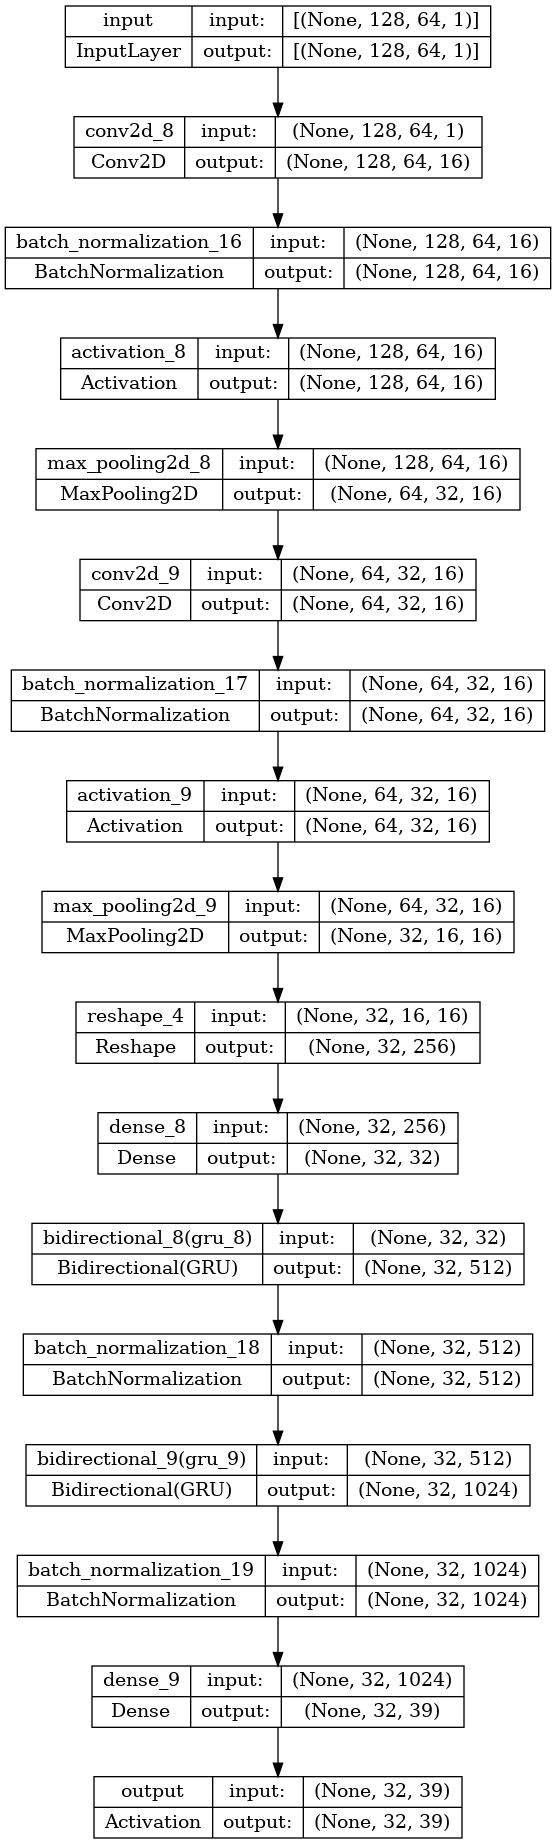

In [86]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

model_architecture_file = os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + '.png'
plot_model(predict_model, to_file=model_architecture_file, show_shapes=True)
Image(filename=model_architecture_file, width=400)

In [163]:
history = train_model.fit(
    train_generator.generator(),
    steps_per_epoch=BATCH_SIZE // BATCH_SIZE,
    validation_data=val_generator.generator(),
    validation_steps=BATCH_SIZE // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=TrainHelper.get_callbacks(OUTPUT_PATH, MODEL_NAME, OPTIMIZER, MODEL_WEIGHTS_PATH), verbose=1)

Epoch 1/1000


2023-02-13 22:24:45.635565: W tensorflow/c/c_api.cc:291] Operation '{name:'batch_normalization_31/cond_3/Identity' id:20522 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_31/cond_3/Identity}} = Identity[T=DT_FLOAT, _has_manual_control_dependencies=true](batch_normalization_31/cond_3)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-13 22:24:47.100491: W tensorflow/c/c_api.cc:291] Operation '{name:'training_12/Adadelta/bidirectional_14/backward_gru_14/gru_cell_44/recurrent_kernel/accum_var/Assign' id:21847 op device:{requested: '', assigned: ''} def:{{{node training_12/Adadelta/bidirectional_14/backward_gru_14/gru_cell_44/recurrent_kernel/accum_var/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adadelta/bidirectional_14/back

1/1 [==============================] - ETA: 0s - batch: 0.0000e+00 - size: 16.0000 - loss: 92.9633

2023-02-13 22:24:52.564087: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss_7/weighted_loss/value' id:20806 op device:{requested: '', assigned: ''} def:{{{node CTCLoss_7/weighted_loss/value}} = DivNoNan[T=DT_FLOAT, _has_manual_control_dependencies=true](CTCLoss_7/weighted_loss/Sum_1, CTCLoss_7/weighted_loss/num_elements/Cast)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Epoch 1: val_loss improved from inf to 83.10610, saving model to output/license_recognition/adadelta/ilpr-model-weights.h5
1/1 [==============================] - 14s 14s/step - batch: 0.0000e+00 - size: 16.0000 - loss: 92.9633 - val_loss: 83.1061
Epoch 2/1000


2023-02-13 22:24:59.294713: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-13 22:24:59.294769: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-02-13 22:24:59.650076: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-13 22:24:59.821300: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


1/1 [==============================] - ETA: 0s - batch: 0.0000e+00 - size: 16.0000 - loss: 133.5954
Epoch 2: val_loss improved from 83.10610 to 72.71529, saving model to output/license_recognition/adadelta/ilpr-model-weights.h5


2023-02-13 22:24:59.858132: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: output/license_recognition/adadelta/logs/plugins/profile/2023_02_13_22_24_59/LeeAarthi.xplane.pb


1/1 [==============================] - 1s 877ms/step - batch: 0.0000e+00 - size: 16.0000 - loss: 133.5954 - val_loss: 72.7153
Epoch 3/1000
1/1 [==============================] - ETA: 0s - batch: 0.0000e+00 - size: 16.0000 - loss: 121.5476
Epoch 3: val_loss improved from 72.71529 to 50.26740, saving model to output/license_recognition/adadelta/ilpr-model-weights.h5
1/1 [==============================] - 0s 472ms/step - batch: 0.0000e+00 - size: 16.0000 - loss: 121.5476 - val_loss: 50.2674
Epoch 4/1000
1/1 [==============================] - ETA: 0s - batch: 0.0000e+00 - size: 16.0000 - loss: 98.2454
Epoch 4: val_loss improved from 50.26740 to 44.18495, saving model to output/license_recognition/adadelta/ilpr-model-weights.h5
1/1 [==============================] - 1s 509ms/step - batch: 0.0000e+00 - size: 16.0000 - loss: 98.2454 - val_loss: 44.1850
Epoch 5/1000
1/1 [==============================] - ETA: 0s - batch: 0.0000e+00 - size: 16.0000 - loss: 74.7494
Epoch 5: val_loss did not impr

In [164]:
from tensorflow.keras.models import save_model

predict_model.load_weights(MODEL_WEIGHTS_PATH)
save_model(predict_model, filepath=MODEL_PATH, save_format="h5")

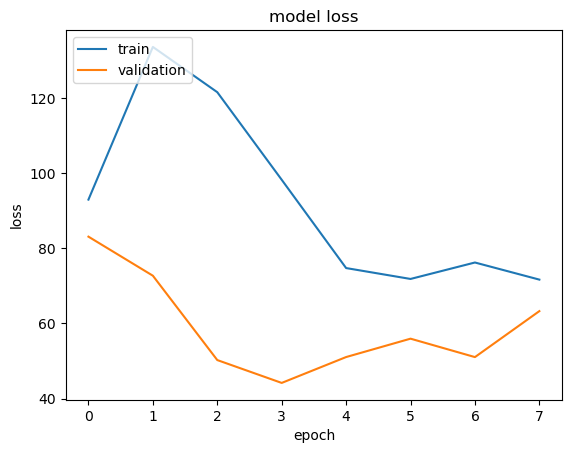

In [165]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + "-train-history-" + OPTIMIZER + ".png")
plt.show()

In [166]:
inputs = next(test_generator.generator())
score = train_model.evaluate(inputs, verbose=0)
print('Test loss: {0:.4f}'.format(score))

Test loss: 51.2353


In [167]:
predict_model.save(SAVED_MODEL_PATH, save_format='tf')

INFO:tensorflow:Assets written to: output/license_recognition/adadelta/saved_model/assets


INFO:tensorflow:Assets written to: output/license_recognition/adadelta/saved_model/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        # Get sample input data as a numpy array in a method of your choosing.
        yield [input]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()